# **Workshop: Tracing Disease Spread Using Genetic and Epidemiological Data**

## **Overview**
In this workshop, students will play the role of molecular epidemiologists investigating an outbreak in a high school. They will use epidemiological data and genetic similarities (pairwise genetic distances) to infer how the disease spread.

## **Learning Objectives**
- Understand how epidemiologists use case information and genetic data to track disease transmission.
- Learn the concept of genetic distances and how they help determine relatedness between infections.
- Develop critical thinking skills by reconstructing a transmission chain.

## **Activity Structure**
1. **Introduction (15 minutes)**
   - Briefly explain how diseases spread and the role of molecular epidemiology.
   - Introduce the concept of genetic distance (i.e., how mutations accumulate as a pathogen spreads).
   - Explain how to interpret a genetic distance matrix.

2. **Solving the Outbreak (40 minutes)**
   - Present the **Case Information Table** and **Genetic Distance Matrix**.
   - Students work in small groups to analyze the data and infer transmission chains.
   - Encourage discussion on uncertainties and alternate explanations.

3. **Discussion and Wrap-Up (20 minutes)**
   - Groups present their findings.
   - Discuss the real-world challenges of outbreak investigations.
   - Highlight key takeaways about combining genetic and epidemiological data.

---

# **Scenario: Outbreak in a High School**

An infectious disease has spread in a high school. Molecular epidemiologists have collected samples from infected students and analyzed their genetic similarities. Your task is to determine who likely infected whom using the available data.


## **Case Information Table**

| Case ID | Symptom Onset Date | Known Contacts | Recent Travel | Sample ID |
|---------|--------------------|---------------|--------------|-----------|
| Alice   | March 2           | Bob, Carol    | No           | S1        |
| Bob     | March 4           | Alice, David  | No           | S2        |
| Carol   | March 6           | Alice, Eve    | No           | S3        |
| David   | March 7           | Bob, Eve      | Yes (London) | S4        |
| Eve     | March 9           | Carol, David  | No           | S5        |

## **Genetic Distance Matrix**

|       | S1 | S2 | S3 | S4 | S5 |
|-------|----|----|----|----|----|
| **S1** | 0  | 1  | 2  | 3  | 3  |
| **S2** | 1  | 0  | 1  | 2  | 3  |
| **S3** | 2  | 1  | 0  | 1  | 2  |
| **S4** | 3  | 2  | 1  | 0  | 1  |
| **S5** | 3  | 3  | 2  | 1  | 0  |

---

## **Student Task**
Using the case information and genetic distance matrix:
1. Identify the most likely **index case** (first infected person).
2. Determine who infected whom.
3. Explain your reasoning using both epidemiological clues (e.g., symptom onset dates, known contacts) and genetic distances.

**Bonus Discussion Questions:**
- What are some challenges of using only genetic distances to infer transmission?
- How might missing cases affect our conclusions?
- What additional data would help confirm the outbreak source?

---

## **Materials Needed**
- Printed handouts with case information and genetic distances.
- Whiteboard or flipchart for group discussions.
- (Optional) Colored markers or sticky notes for mapping transmission chains.

## **Wrap-Up**
Conclude by discussing how real-world outbreak investigations work and how molecular epidemiology informs public health responses.

---

This Markdown version is ready for copying and pasting into any document or platform that supports Markdown formatting.

In [31]:
import random
from datetime import timedelta
import sciris as sc
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

```python
param_dict = {
    "r0": 1.5,
    "k": 0.5,
    "seed_infections": 1,
    "total_infections": 50,
    "gen_length": 1000,  # Didn't use actual genome length 29903 to reduce computational time
    "prop_sampled": 1,
    "sampling_delay": 0.0,
}

para_name = "sampling_delay"
param_range = [0.0, 0.1]

simulations = run_simulations(param_dict, para_name, param_range, use_parallel=True)
sc.save("/Users/ydnkka/Desktop/Repositories/PESC-Activity/outbreaks.obj", simulations)
```

In [2]:
simulations = sc.load("outbreaks.obj")
base_sim = simulations[0]
some_noise = simulations[1]

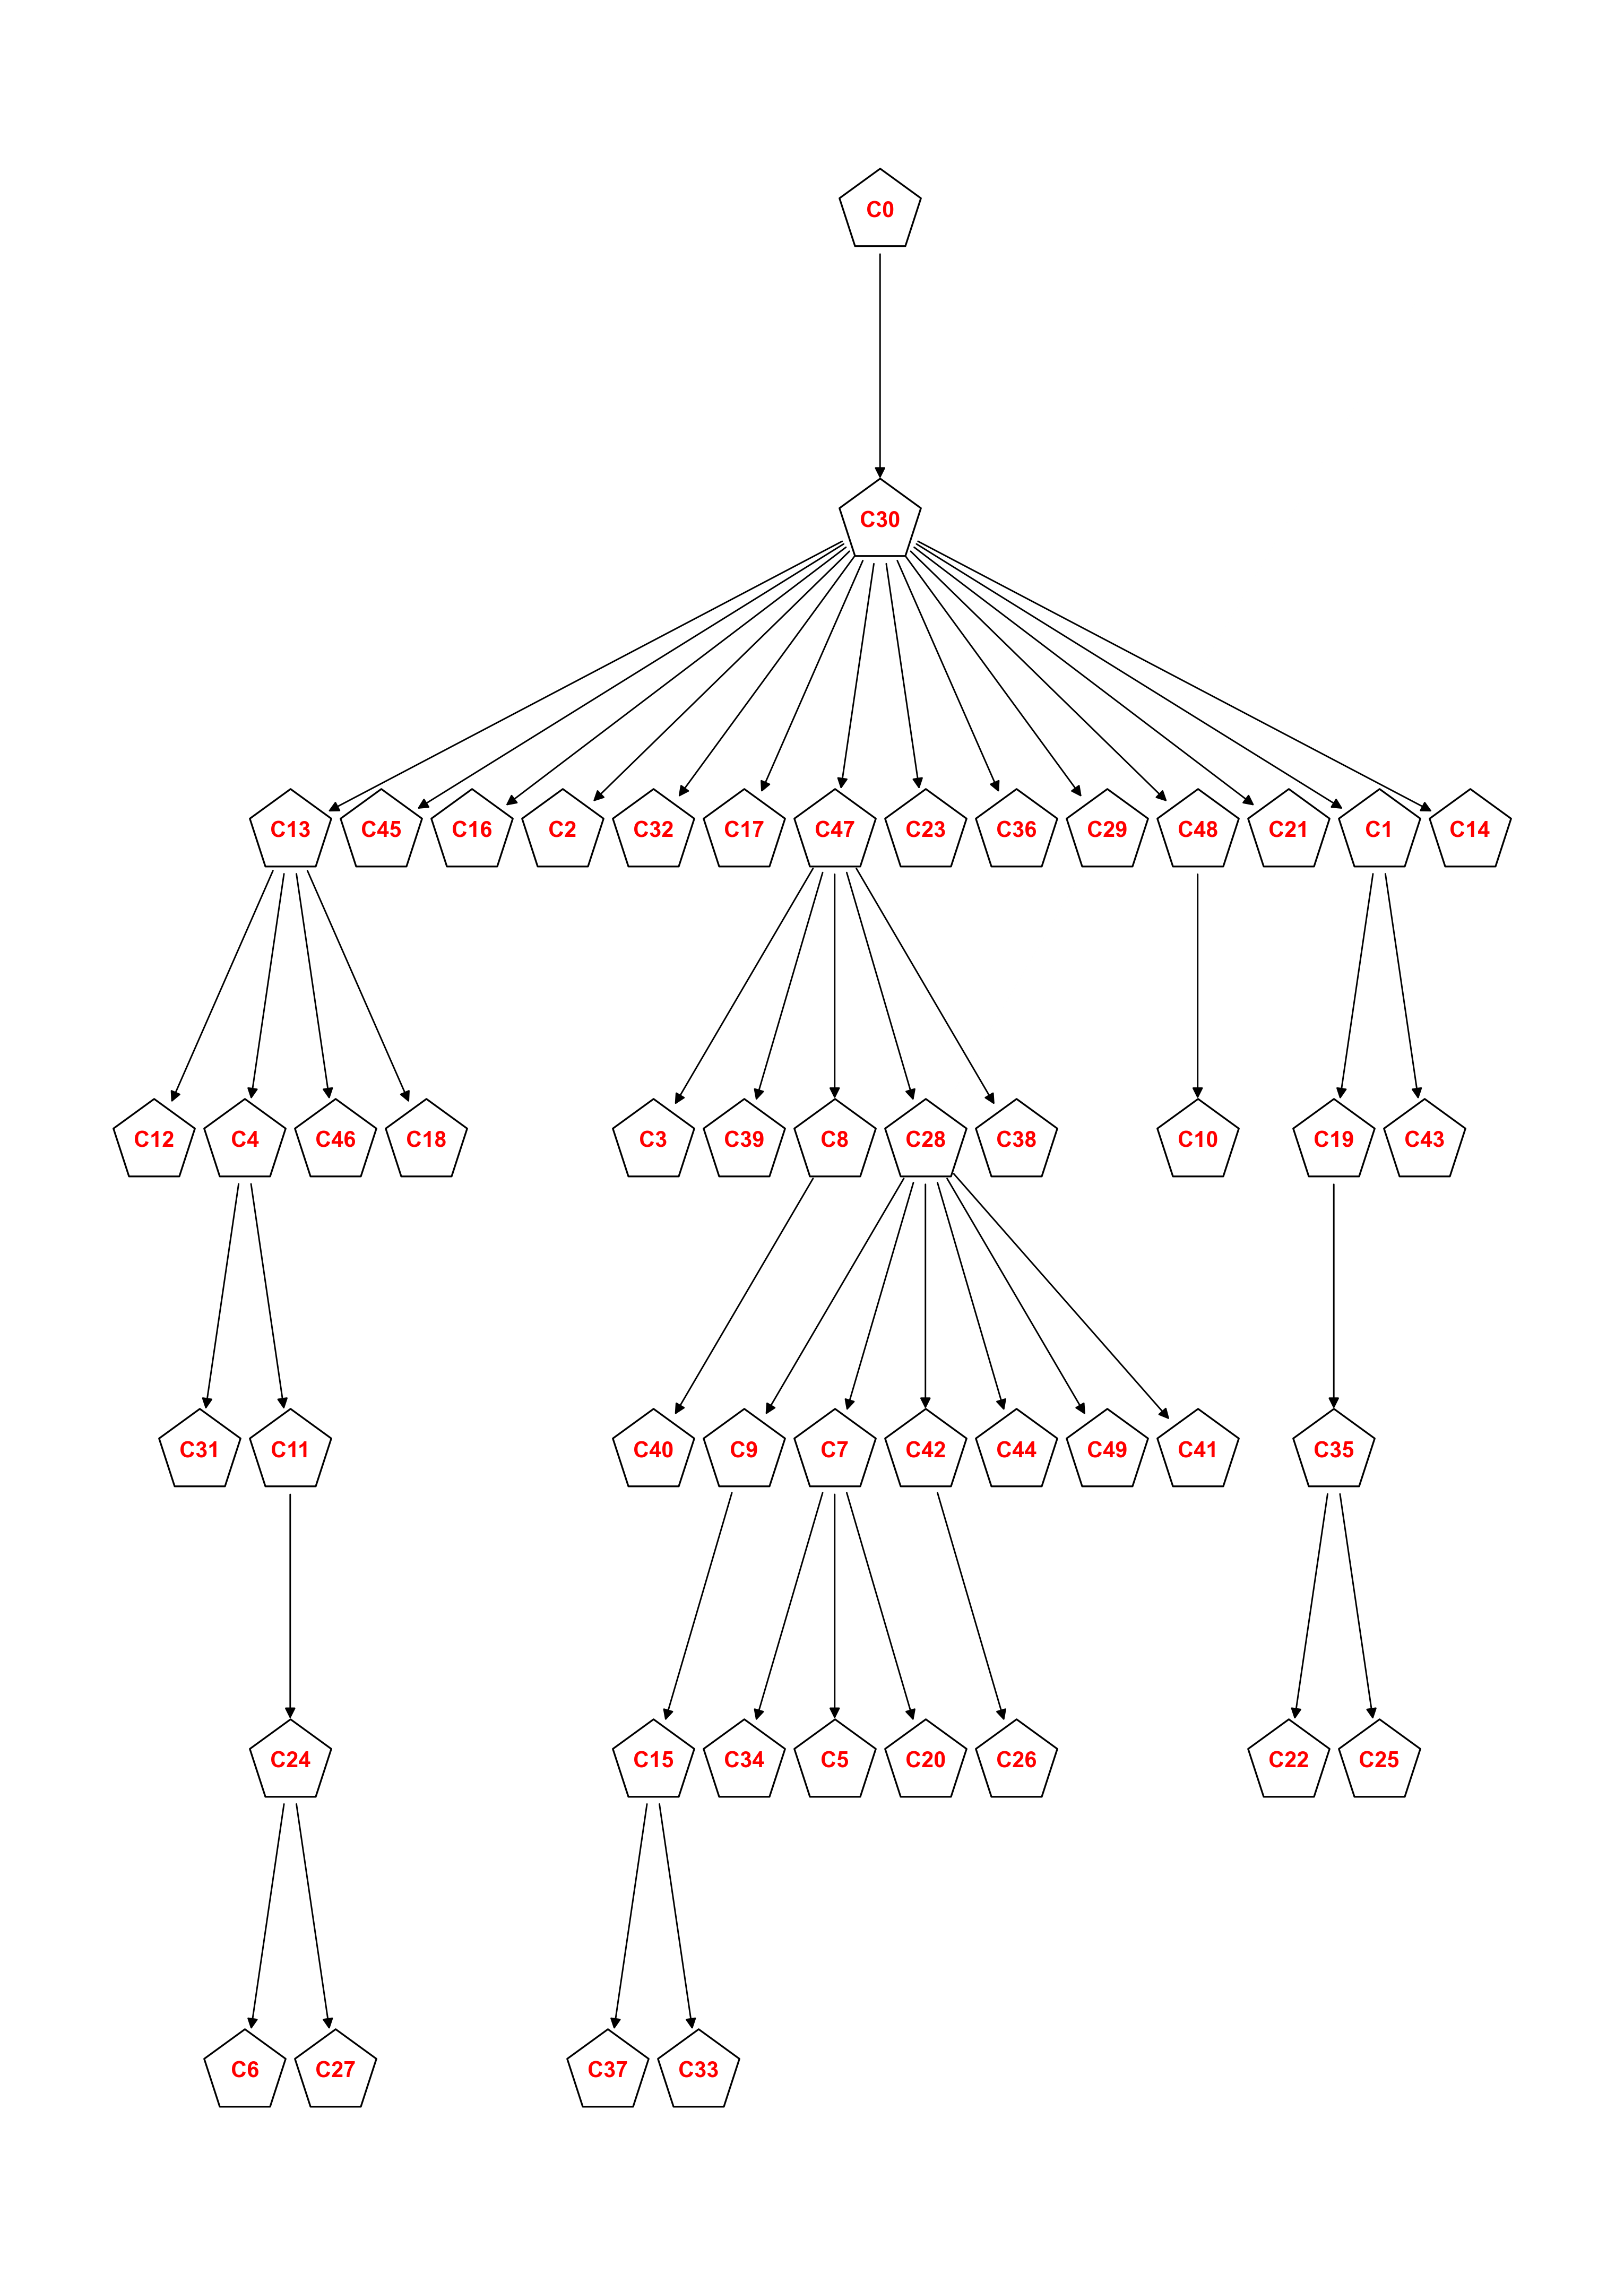

In [101]:
tree = base_sim.tree
original_nodes = list(tree.nodes())
shuffled_nodes = random.sample(original_nodes, len(original_nodes))
node_name_mapping = {original_nodes[i]: f"C{shuffled_nodes[i]}" for i in range(len(original_nodes))}
tree = nx.relabel_nodes(tree, node_name_mapping)

pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
aspect_ratio = 1.414
width = 10
plt.figure(figsize=(width, width*aspect_ratio), dpi=300)  # Increase the figure size
nx.draw(tree, pos,
        with_labels=True,
        width=0.7,
        edge_color='black',
        node_size=1500,
        font_color='red',
        font_size=10,
        font_weight='bold',
        node_color='white',
        edgecolors='black',
        node_shape='p',
        hide_ticks=False)

plt.savefig("transmission_tree.png", dpi=300)
plt.show()

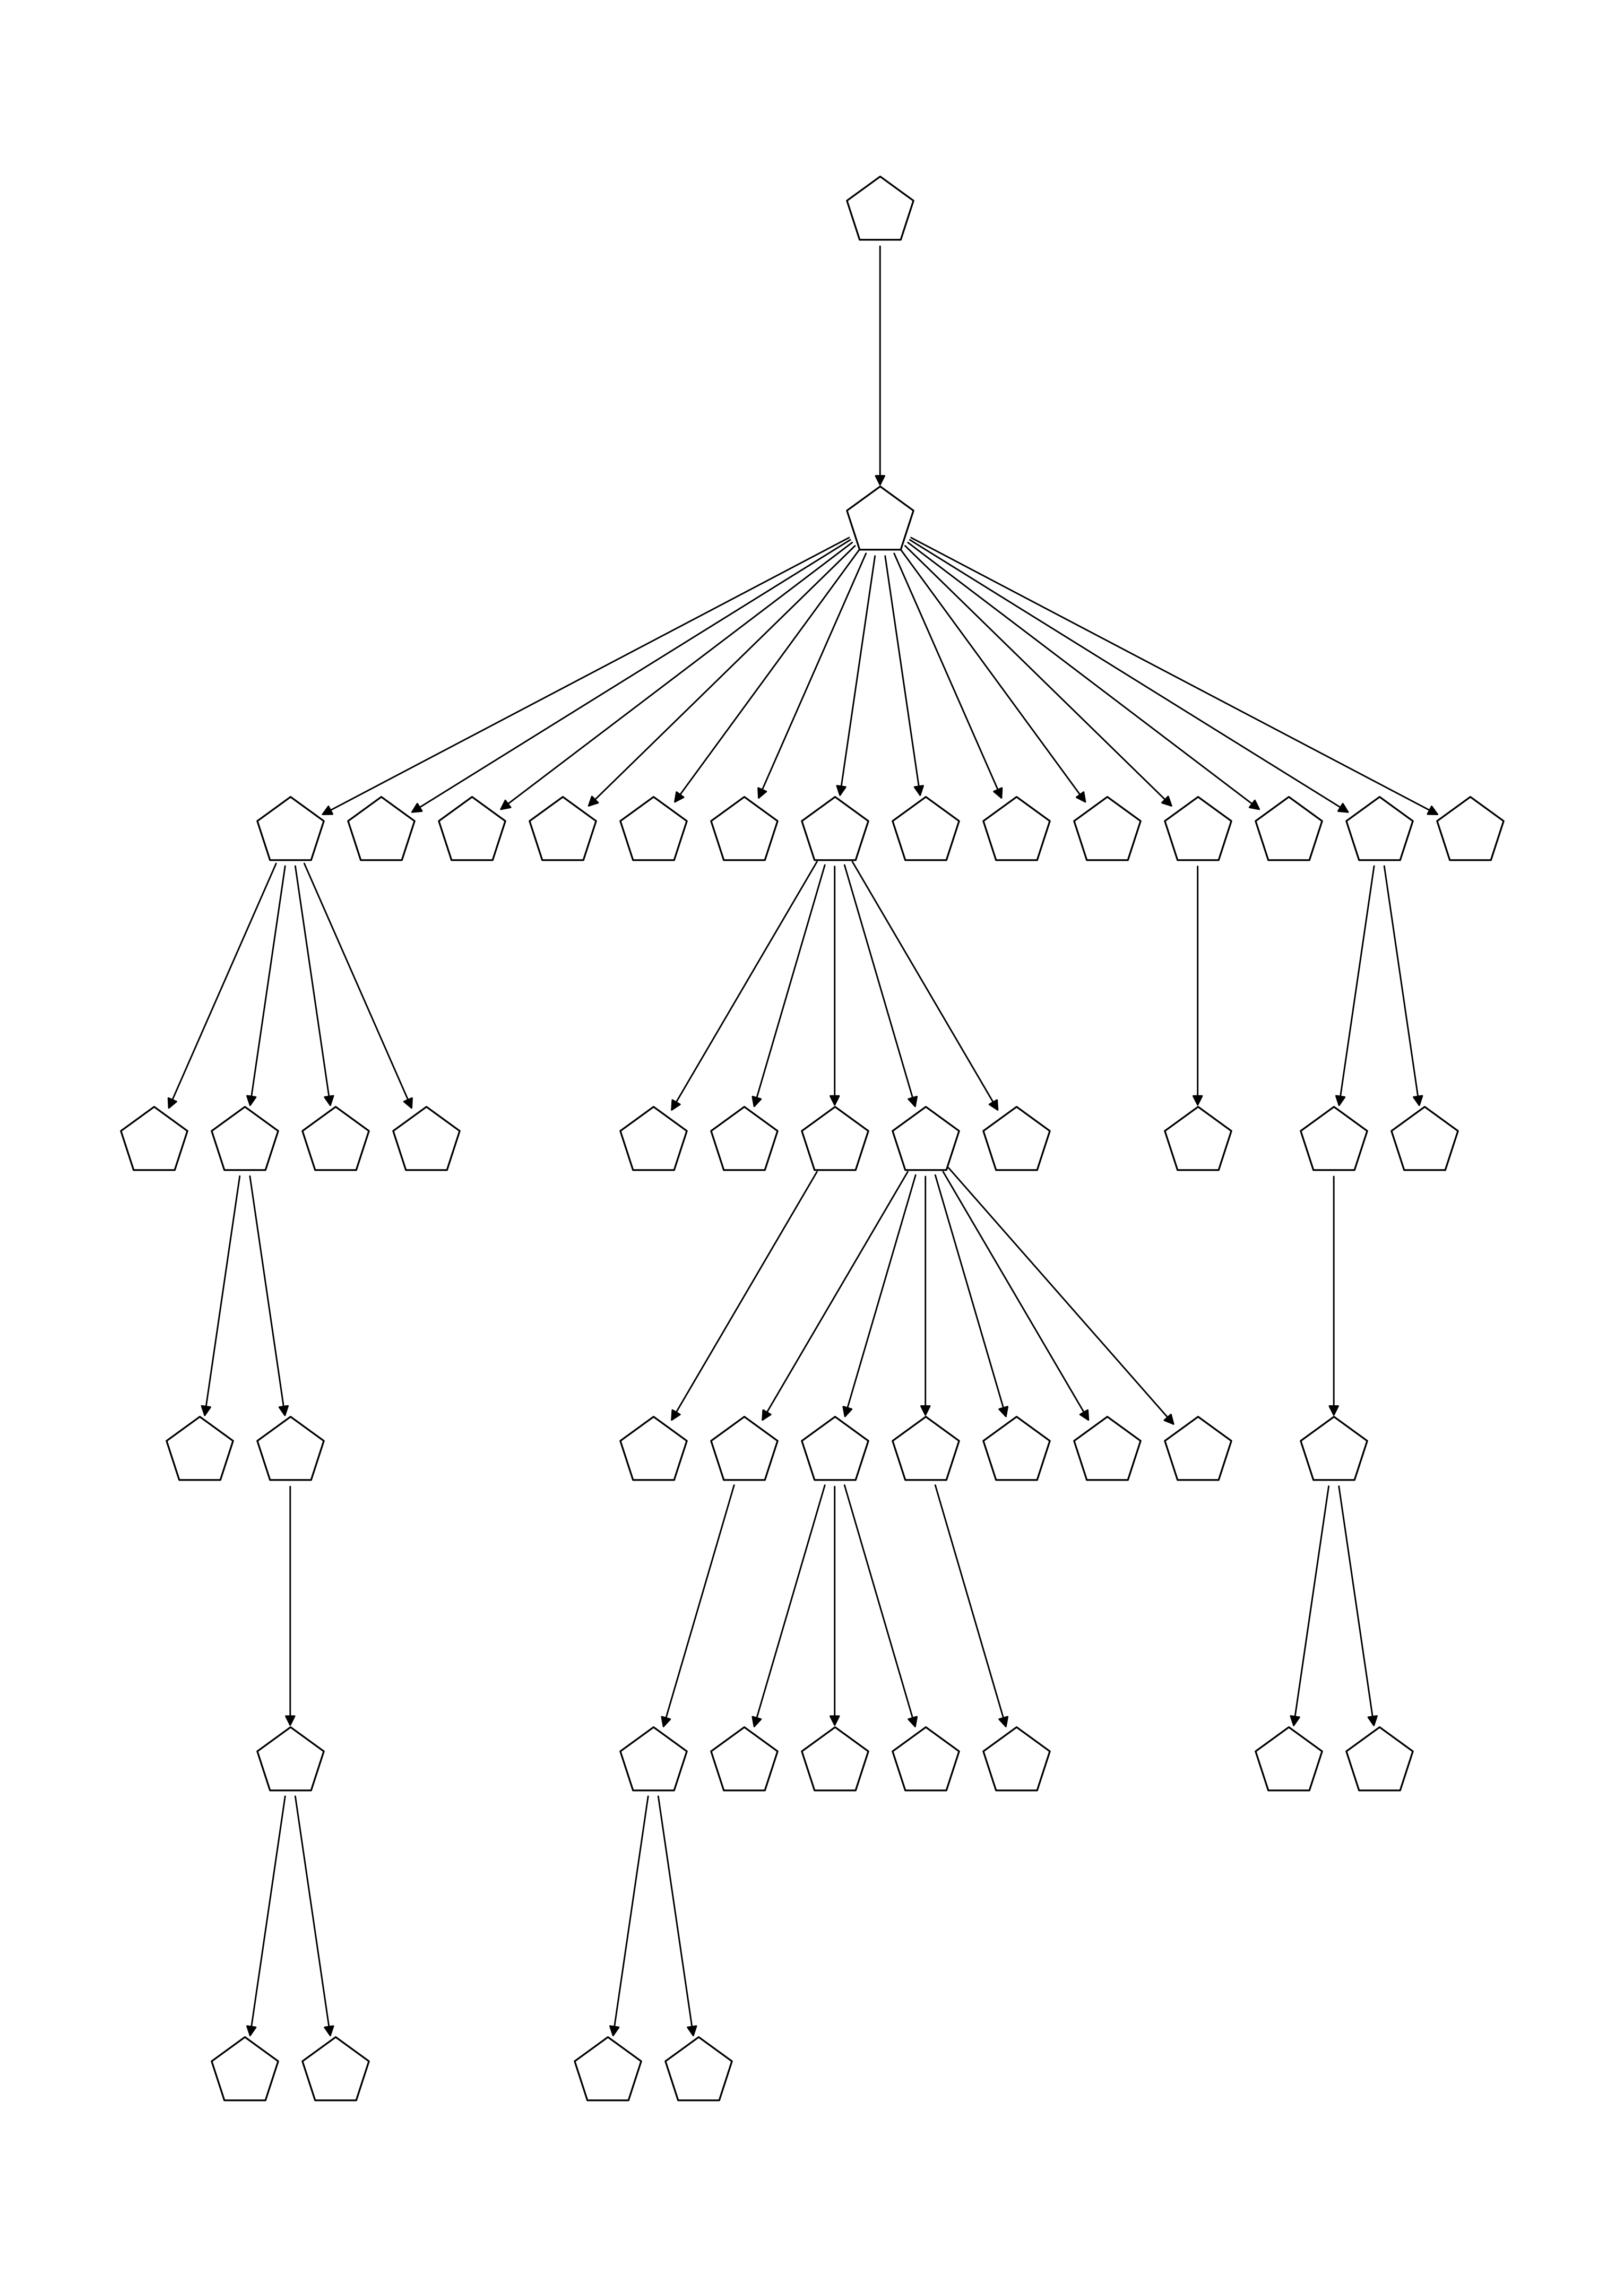

In [102]:
plt.figure(figsize=(width, width*aspect_ratio), dpi=300)  # Increase the figure size
nx.draw(tree, pos,
        with_labels=False,
        edge_color='black',
        width=0.7,
        node_size=1000,
        font_size=10,
        font_weight='bold',
        node_color='white',
        edgecolors='black',
        node_shape='p',
        hide_ticks=False)


plt.savefig("transmission_tree_blank.png", dpi=300)
plt.show()

In [97]:
transmission_data = nx.to_pandas_edgelist(tree)
transmission_data = transmission_data[["source", "target"]].copy()
transmission_data.rename(columns={"source": "Infector", "target": "Infectee"}, inplace=True)

transmission_data.to_csv("transmission_data.csv", index=False)

In [98]:
cases = pd.DataFrame(dict(tree.nodes)).T
cases = cases[["exp_date", "date_symptom_onset"]].copy().astype(int)

cases.reset_index(inplace=True, names=["Case ID"])
cases.rename(columns={"exp_date": "Exposure Date", "date_symptom_onset": "Symptom Onset Date"},
             inplace=True)

cases.sort_values("Exposure Date", inplace=True)

start_date = pd.Timestamp("2020-01-01")
cases["Exposure Date"] = cases["Exposure Date"].apply(lambda x: start_date + timedelta(days=x - 1))
cases["Symptom Onset Date"] = cases["Symptom Onset Date"].apply(lambda x: start_date + timedelta(days=x - 1))

cases.to_csv("cases.csv", index=False)

In [103]:
def get_distance_matrix(sequences):
    keys = list(sequences.keys())
    matrix = np.array(list(sequences.values()))

    # Convert nucleotide sequences to numerical values for Hamming distance calculation
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    seq_matrix_num = np.vectorize(mapping.get)(matrix)
    distances = pdist(seq_matrix_num, metric='hamming')  # Proportion of differing sites
    return squareform(distances), keys, matrix

hamming_distances, ids, seq_matrix = get_distance_matrix(base_sim.result.linearSeqSim)
hamming_matrix = hamming_distances * seq_matrix.shape[1]  # convert to number of differing positions
hamming_matrix = hamming_matrix.astype(int)

ids = [node_name_mapping[x] for x in ids]
pairwise_distances = pd.DataFrame(hamming_matrix, index=ids, columns=ids)

pairwise_distances.columns.name = "Case ID"
pairwise_distances.index.name = "Case ID"

pairwise_distances.to_csv("pairwise_distances.csv")

In [100]:
pairwise_distances

Case ID,C4,C16,C33,C32,C31,C19,C36,C10,C5,C15,...,C22,C23,C35,C11,C18,C30,C1,C44,C37,C43
Case ID,,,,,,,,,,,,,,,,,,,,,
C4,0,1,2,3,3,4,4,5,6,6,...,2,3,1,2,3,4,5,5,3,2
C16,1,0,1,2,2,3,3,4,5,5,...,1,2,1,1,2,3,4,4,2,1
C33,2,1,0,1,1,2,2,3,4,4,...,2,3,2,2,3,4,5,5,3,2
C32,3,2,1,0,2,3,3,4,5,5,...,3,4,3,3,4,5,6,6,4,3
C31,3,2,1,2,0,1,1,2,3,3,...,3,4,3,3,4,5,6,6,4,3
C19,4,3,2,3,1,0,2,3,4,4,...,4,5,4,4,5,6,7,7,5,4
C36,4,3,2,3,1,2,0,1,2,2,...,4,5,4,4,5,6,7,7,5,4
C10,5,4,3,4,2,3,1,0,1,1,...,5,6,5,5,6,7,8,8,6,5
C5,6,5,4,5,3,4,2,1,0,2,...,6,7,6,6,7,8,9,9,7,6


In [25]:
mask = np.triu(np.ones(pairwise_distances.shape), k=1)

# Apply the mask to set the upper triangle to NaN
pairwise_distances_masked = pairwise_distances.mask(mask == 1)